In [1]:
# 05_data_summary_exploration.ipynb

# ✅ Notebook Goal:
# Provide descriptive statistics and summaries to explore the structure and content of both databases

import pandas as pd
import pymongo
import sqlite3
import matplotlib.pyplot as plt

# --- MongoDB Setup ---
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_collection = mongo_client["openfda_converted"]["full_reports"]

# --- SQLite Setup ---
sqlite_conn = sqlite3.connect("../../sql/openfda_base_updated.db")

SQLite - Summary of patient age
       patientonsetage
count     23542.000000
mean        122.336293
std        1290.302712
min           0.000000
25%          41.000000
50%          59.000000
75%          71.000000
max       34377.000000


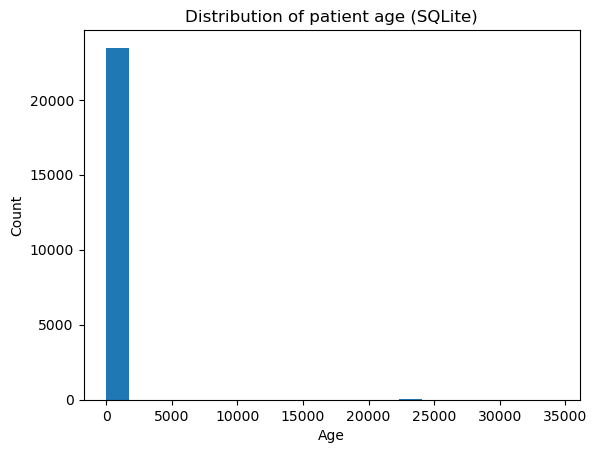

In [2]:
# --- 1. Basic Summary Statistics from SQLite ---
print("SQLite - Summary of patient age")
age_df = pd.read_sql_query("SELECT patientonsetage FROM patient_optional WHERE patientonsetage IS NOT NULL", sqlite_conn)
print(age_df.describe())

plt.hist(age_df["patientonsetage"], bins=20)
plt.title("Distribution of patient age (SQLite)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [4]:
# --- 2. Common Drugs and Indications ---
print("\nSQLite - Top 10 drugs and indications:")
drug_counts = pd.read_sql_query("""
    SELECT medicinalproduct, COUNT(*) as cnt 
    FROM drug 
    GROUP BY medicinalproduct 
    ORDER BY cnt DESC LIMIT 10
""", sqlite_conn)

print(drug_counts.head(10))

indication_counts = pd.read_sql_query("""
    SELECT drugindication, COUNT(*) as cnt 
    FROM drug 
    WHERE drugindication IS NOT NULL
    GROUP BY drugindication 
    ORDER BY cnt DESC LIMIT 10
""", sqlite_conn)
print(indication_counts)


SQLite - Top 10 drugs and indications:
  medicinalproduct    cnt
0         MOUNJARO  10191
1         DUPIXENT   3700
2        INFLECTRA   2569
3       PREDNISONE   2386
4     METHOTREXATE   2106
5          REPATHA   1803
6    ACETAMINOPHEN   1479
7        RITUXIMAB   1419
8    DEXAMETHASONE   1306
9          ASPIRIN   1295
                        drugindication    cnt
0  Product used for unknown indication  52531
1                 Rheumatoid arthritis   4359
2             Type 2 diabetes mellitus   2203
3                  Plasma cell myeloma   1911
4                    Dermatitis atopic   1520
5                         Hypertension   1369
6                               Asthma   1163
7                      Crohn^s disease   1011
8                    Diabetes mellitus   1005
9                          Prophylaxis    983



MongoDB - Reaction count per report distribution:


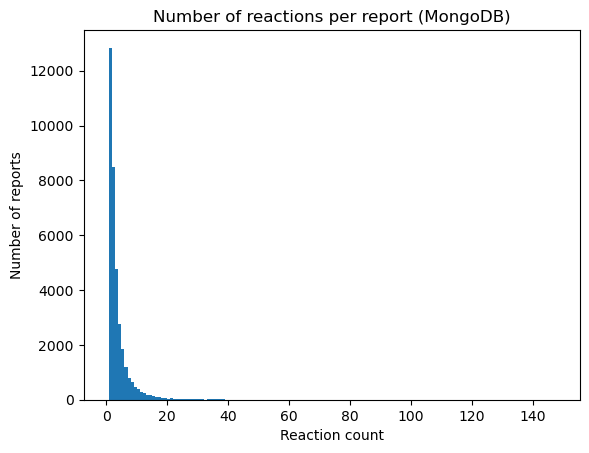

In [5]:
# --- 3. MongoDB - Number of Reactions per Report ---
print("\nMongoDB - Reaction count per report distribution:")
pipeline = [
    {"$project": {"reaction_count": {"$size": {"$ifNull": ["$patient.reaction", []]}}}}
]
reaction_data = list(mongo_collection.aggregate(pipeline))

reaction_df = pd.DataFrame(reaction_data)
plt.hist(reaction_df["reaction_count"], bins=range(0, reaction_df["reaction_count"].max() + 2))
plt.title("Number of reactions per report (MongoDB)")
plt.xlabel("Reaction count")
plt.ylabel("Number of reports")
plt.show()

In [7]:
# --- 4. Optional: Count optional fields usage ---
print("\nMongoDB - Reports with case_event_date_extracted:")
event_count = mongo_collection.count_documents({"patient.summary.case_event_date_extracted": {"$exists": True}})
print(f"Documents with extracted case event date: {event_count}")



MongoDB - Reports with case_event_date_extracted:
Documents with extracted case event date: 16948


In [9]:
# Cleanup
sqlite_conn.close()
mongo_client.close()